In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import joblib

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/data")
df_rf_15 = pd.read_csv('df_rf_15.csv')
df_rf_20 = pd.read_csv('df_rf_20.csv')
df_rf_25 = pd.read_csv('df_rf_25.csv')
df_rf_30 = pd.read_csv('df_rf_30.csv')
df_rf_35 = pd.read_csv('df_rf_35.csv')
df_rf_40 = pd.read_csv('df_rf_40.csv')
df_rf_45 = pd.read_csv('df_rf_45.csv')
heroes= pd.read_csv('heroes.csv')
heroes = heroes.rename(columns = {'id':'hero_id'})
df2_allhero = pd.read_csv('df2_allhero.csv') # We use this to instantiate the embedding layer since thats how the embedding layers were created and i want to avoid any shenanigans like the hero_ids and their indexes getting jumbled due to ordering when they get mapped by hero_id_to_idx

os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/")
%run LSTM_Model_Classes_dynamic.ipynb

os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/lstm")
model_dict_10_5_rmse_84 = torch.load('10step_5horizon_RMSE_84.pth') #done
model_dict_5_5_rmse_84 = torch.load('5step_5horizon_RMSE_84.pth') #error?
model_dict_10_5_rmse_8 = torch.load('10step_5horizon_RMSE_8.pth') #done
model_dict_5_5_rmse_8 = torch.load('5step_5horizon_RMSE_8.pth') #done


In [4]:
def drop_columns(df):
  cols_to_drop = df.filter(regex=r'\d_gold$').columns #removing tensor columns
  df = df.drop(columns= cols_to_drop)
  return df

def split_data(df, test_size):
  X = df.drop('winner', axis=1)
  y = df['winner']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  return X_train, X_test, y_train, y_test

In [5]:
def iterate_ids(id_array):
  # Takes in a numpy array, and feeds the values one by one into the embedding layer
  # Returns the embedding representation that can replace the column
  hero_embeddings_list = []
  for hero_id in id_array:
      embedding = RMSE_embedding(hero_id).detach().numpy()
      hero_embeddings_list.append(embedding)

  #print(hero_embeddings_list)

  hero_embeddings_tensor = torch.tensor(hero_embeddings_list)
  return hero_embeddings_tensor

In [ ]:
# We need to loop over the hero_id's since the ProcessEmbedding layer is expecting one hero_id at a time

# Below is commented out to show that depending on which dataframe we feed the hero_ids from we get different tensor embeddings.
# We will stick with the original embedding although it should technically work the same

# hero_embeddings = []
# for hero_id in heroes['hero_id']:
#     embedding = RMSE_embedding(hero_id)
#     hero_embeddings.append(embedding)

# hero_embeddings = torch.stack(hero_embeddings)

# hero_embeddings_df2 = []
# for hero_id in df2_allhero['hero_id']:
#     embedding = RMSE_embedding(hero_id)
#     hero_embeddings_df2.append(embedding)

# hero_embeddings_df2 = torch.stack(hero_embeddings_df2)

# hero_embeddings_df2 == hero_embeddings

In [ ]:
# embed_test = iterate_ids(df_rf_15['rad_pos1'].values)
# embed_test

In [6]:
def get_hero_embedding_and_concat_features(df):
  # Extract the hero_ids for each position from your dataframe

  hero_columns = ['rad_pos1', 'rad_pos2', 'rad_pos3', 'rad_pos4', 'rad_pos5',
                'dire_pos1', 'dire_pos2', 'dire_pos3', 'dire_pos4', 'dire_pos5']

  hero_embeddings = {col: iterate_ids(df[col].values) for col in hero_columns}

  # Create new columns for each hero position's embedded representations
  embedded_columns = {}
  for col in hero_columns:
      embeddings = hero_embeddings[col].detach().numpy()
      embeddings = embeddings.reshape(embeddings.shape[0],-1)
      #print(embeddings.shape)
      num_rows, num_features = embeddings.shape
      for i in range(num_features):
        embedded_columns[f"{col}_embed_{i+1}"] = embeddings[:, i].flatten()


  # Get the embedding vectors for each position using the trained embedding layer
  # We need to call another .detach().numpy() here since we were still getting the autograd error from PyTorch
  # We also needed to reshape the embeddings to remove an extra dimension, without the reshape(-1,84), their shapes were (995, 1, 84) now they're (995,84)

  combined_features_df = pd.DataFrame({
      **embedded_columns, # '**' unpacks a dictionary and passes the dict as key-value pais
      # this effectively replaces typing the below:
      #'rad_pos1_embed_1 : [..],
      #'rad_pos1_embed_2 : [..]

      'rad_pos1_last_gold': df['rad_pos1_last_gold'],
      'rad_pos2_last_gold': df['rad_pos2_last_gold'],
      'rad_pos3_last_gold': df['rad_pos3_last_gold'],
      'rad_pos4_last_gold': df['rad_pos4_last_gold'],
      'rad_pos5_last_gold': df['rad_pos5_last_gold'],
      'dire_pos1_last_gold': df['dire_pos1_last_gold'],
      'dire_pos2_last_gold': df['dire_pos2_last_gold'],
      'dire_pos3_last_gold': df['dire_pos3_last_gold'],
      'dire_pos4_last_gold': df['dire_pos4_last_gold'],
      'dire_pos5_last_gold': df['dire_pos5_last_gold'],
      'pos1_diff': df['pos1_diff'],
      'pos2_diff': df['pos2_diff'],
      'pos3_diff': df['pos3_diff'],
      'pos4_diff': df['pos4_diff'],
      'pos5_diff': df['pos5_diff'],
      'team_diff': df['team_diff'],
      'winner': df['winner']
  })

  return combined_features_df

#df_rf_15_embed = get_hero_embedding_and_concat_features(df_rf_15)


Split RF Structures for Model Training

In [17]:
def create_save_plots(rf_classifier_name, X_test_name, y_test_name, df,file_name):
  from sklearn.tree import plot_tree
  #RF_No_Predict_No_Embed
  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots/embed_rf")
  # Evaluate each tree in the random forest classifier
  tree_accuracies = []

  y_test_name = y_test_name.replace({'dire': 0, 'radiant': 1})

  for tree in rf_classifier_name.estimators_:
      y_pred_tree = tree.predict(X_test_name)
      accuracy_tree = accuracy_score(y_test_name, y_pred_tree)
      tree_accuracies.append(accuracy_tree)

  # Find the index of the tree with the highest accuracy
  best_tree_index = np.argmax(tree_accuracies)
  best_tree = rf_classifier_name.estimators_[best_tree_index]
  best_tree_accuracy = tree_accuracies[best_tree_index]

  # Plot a decision tree from the random forest
  plt.figure(figsize=(12, 8))
  plt.title(f"Best Tree: {best_tree_accuracy}\n Acc: {best_tree_accuracy}")
  plot_tree(best_tree, filled=True, rounded=True, feature_names=df.columns[:-1].tolist())
  plt.savefig(f'{file_name}_Best_Tree.png')
  plt.show()

  # Plot feature importances
  importances = rf_classifier_name.feature_importances_
  indices = np.argsort(importances)[::-1]
  feature_names = df.columns[:-1]
  #print(importances)
  #print(feature_names)

  # Select the top 15 features
  top_n = 20
  top_indices = indices[:top_n]
  top_feature_names = [feature_names[i] for i in top_indices]
  top_importances = importances[top_indices]

  plt.figure(figsize=(10, 6))
  plt.title(f"Top {top_n} Feature Importances")
  plt.bar(range(top_n), top_importances)
  plt.xticks(range(top_n), top_feature_names, rotation=90)
  plt.ylabel('Feature Importance')
  plt.tight_layout()
  plt.savefig(f'{file_name}_Tree_Importances.png')
  plt.show()

  os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/embed_rf")

In [ ]:
#print(rf_15_y_test,rf_15_y_pred)

In [ ]:
#df_rf_15.columns

Change this section when you want to run results for each dataframe once you've chosen which LSTM embeds you want to use

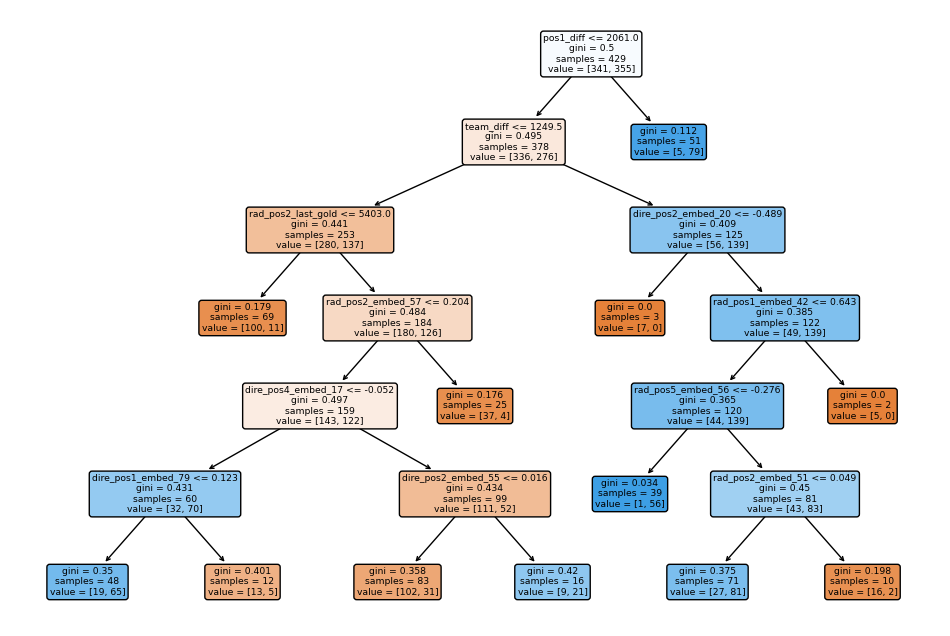

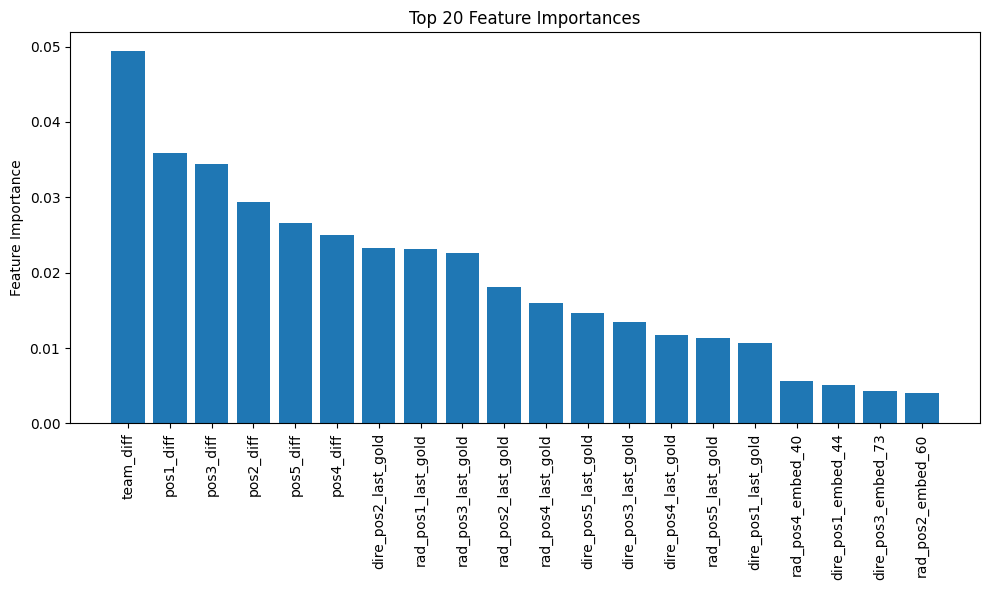

RF_15_embed:          Acc  Prec    Recall        F1
0  0.715719   0.7  0.777778  0.736842


In [45]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/lstm")
model_dict_10_5_rmse_84 = torch.load('10step_5horizon_RMSE_84.pth') #done
model_dict_5_5_rmse_84 = torch.load('5step_5horizon_RMSE_84.pth') #error?
model_dict_10_5_rmse_8 = torch.load('10step_5horizon_RMSE_8.pth') #done
model_dict_5_5_rmse_8 = torch.load('5step_5horizon_RMSE_8.pth') #done

import joblib
import warnings

warnings.filterwarnings('ignore')
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/embed_rf")

#10step_5Horizon_rmse_84
lookback = 10
horizon = 5
embed_dim = 84
model_dict = model_dict_10_5_rmse_84
file_name = 'rf_15_test'
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, ccp_alpha=0.01)

RMSE_embedding = ProcessEmbedding(df2_allhero, embedding_dim=embed_dim, lookback=lookback)
RMSE_embed_weights = model_dict_10_5_rmse_84['process_embedding.process_embeddings.weight']
RMSE_embedding.process_embeddings.weight = nn.Parameter(RMSE_embed_weights) # Load the old weights into the new embedding layer

df_rf_15 = drop_columns(df_rf_15)
df_rf_15_embed = get_hero_embedding_and_concat_features(df_rf_15)
rf_15_X_train, rf_15_X_test, rf_15_y_train, rf_15_y_test = split_data(df_rf_15_embed, test_size = .30)

rf_classifier_15 = rf_classifier.fit(rf_15_X_train, rf_15_y_train)
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/embed_rf")
joblib.dump(rf_classifier_15, 'rf_classifier_15.pkl')
rf_15_y_pred = rf_classifier_15.predict(rf_15_X_test)
acc_15 = accuracy_score(rf_15_y_test,rf_15_y_pred)

rf_15_y_test_binary = rf_15_y_test.replace({'dire': 0, 'radiant': 1})
label_mapping = {'dire': 0, 'radiant': 1}
label_mapper = np.vectorize(lambda x: label_mapping[x])
rf_15_y_pred_binary = label_mapper(rf_15_y_pred)

prec_15 = precision_score(rf_15_y_test_binary,rf_15_y_pred_binary)
recall_15 = recall_score(rf_15_y_test_binary,rf_15_y_pred_binary)
f1_15 = f1_score(rf_15_y_test_binary,rf_15_y_pred_binary)

create_save_plots(rf_classifier_15, rf_15_X_test, rf_15_y_test,df_rf_15_embed,file_name)
metrics_15_embed = pd.DataFrame([[acc_15,prec_15,recall_15,f1_15]], columns =['Acc','Prec','Recall','F1'])
metrics_15_embed.to_csv('RF_15_embed_metrics.csv')
print('RF_15_embed: ',metrics_15_embed)

In [23]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/lstm")
# model_dict_10_5_rmse_84 = torch.load('10step_5horizon_RMSE_84.pth') #done
# model_dict_5_5_rmse_84 = torch.load('5step_5horizon_RMSE_84.pth') #error?
# model_dict_10_5_rmse_8 = torch.load('10step_5horizon_RMSE_8.pth') #done
# model_dict_5_5_rmse_8 = torch.load('5step_5horizon_RMSE_8.pth') #done

model_dict_10_1_rmse_8 = torch.load('10step_1horizon_RMSE_8.pth') #done
model_dict = model_dict_10_1_rmse_8
embed_dim = 8
lookback = 10

RMSE_embedding = ProcessEmbedding(df2_allhero, embedding_dim=embed_dim, lookback=lookback)
RMSE_embed_weights = model_dict['process_embedding.process_embeddings.weight']
RMSE_embedding.process_embeddings.weight = nn.Parameter(RMSE_embed_weights) # Load the old weights into the new embedding layer


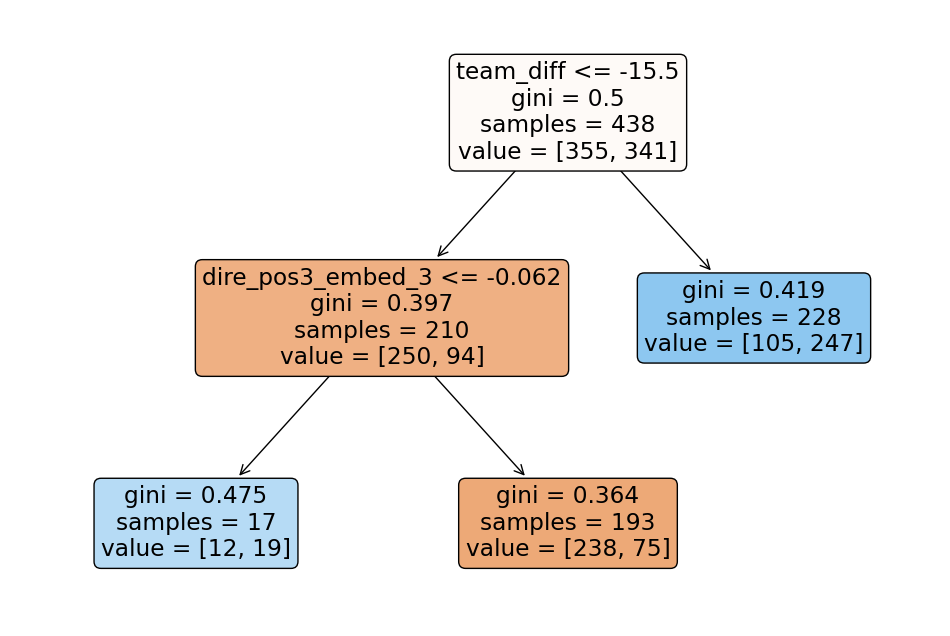

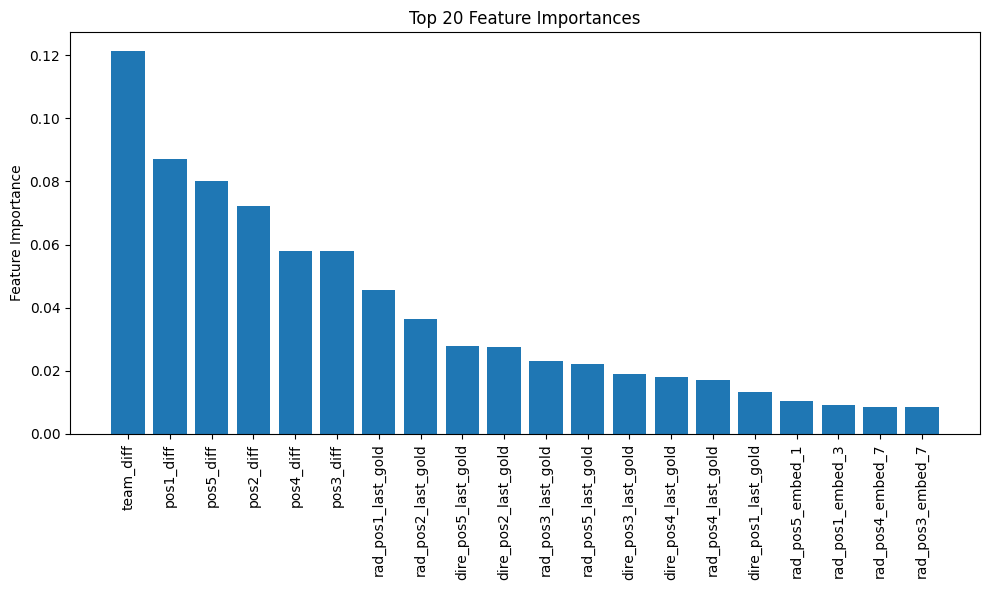

RF_15:         Acc      Prec    Recall        F1
0  0.702341  0.702459  0.702341  0.702014


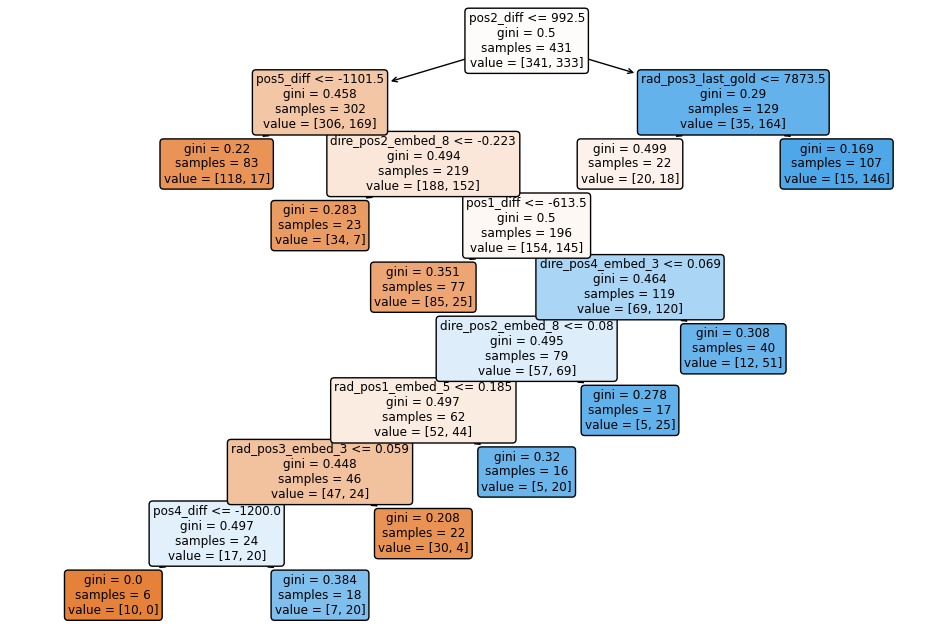

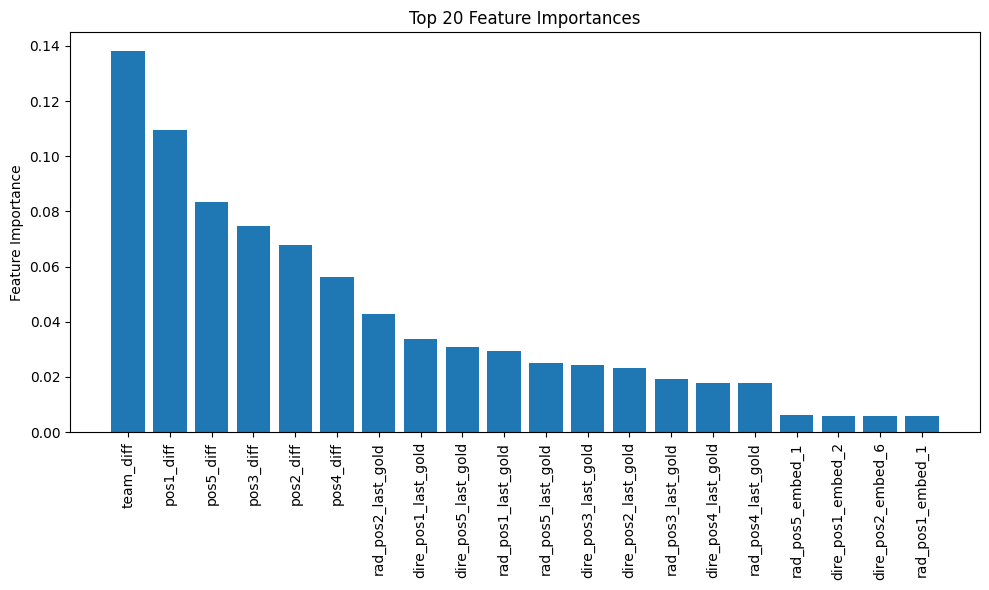

RF_20:         Acc     Prec    Recall        F1
0  0.757785  0.75787  0.757785  0.757791


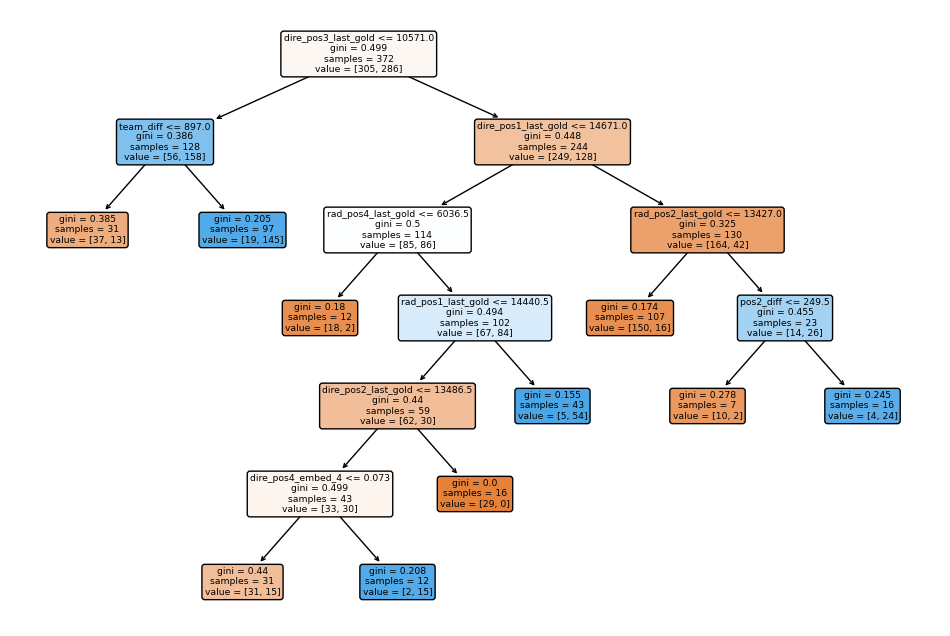

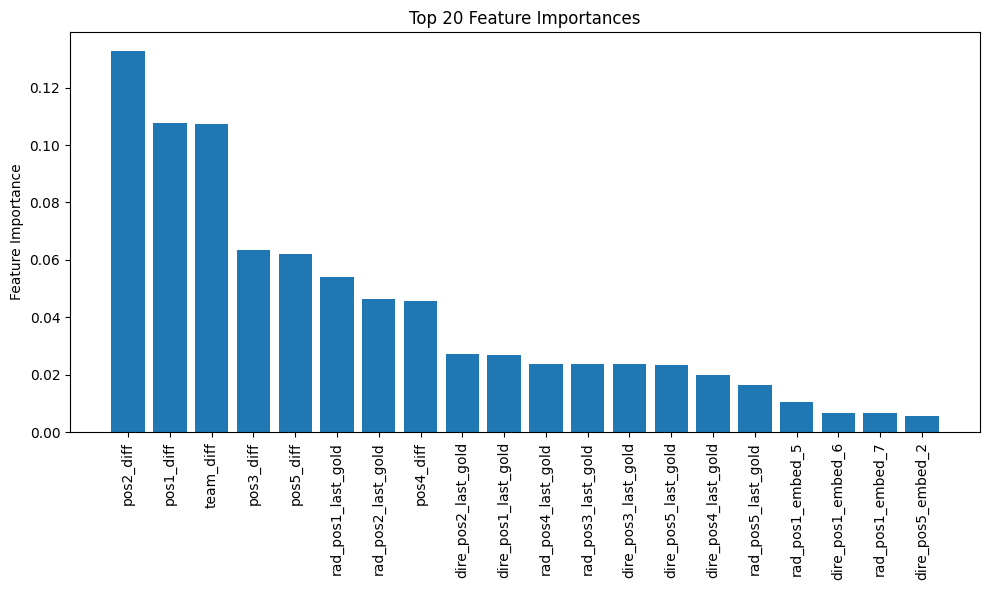

RF_25:         Acc     Prec    Recall        F1
0  0.767717  0.76769  0.767717  0.767691


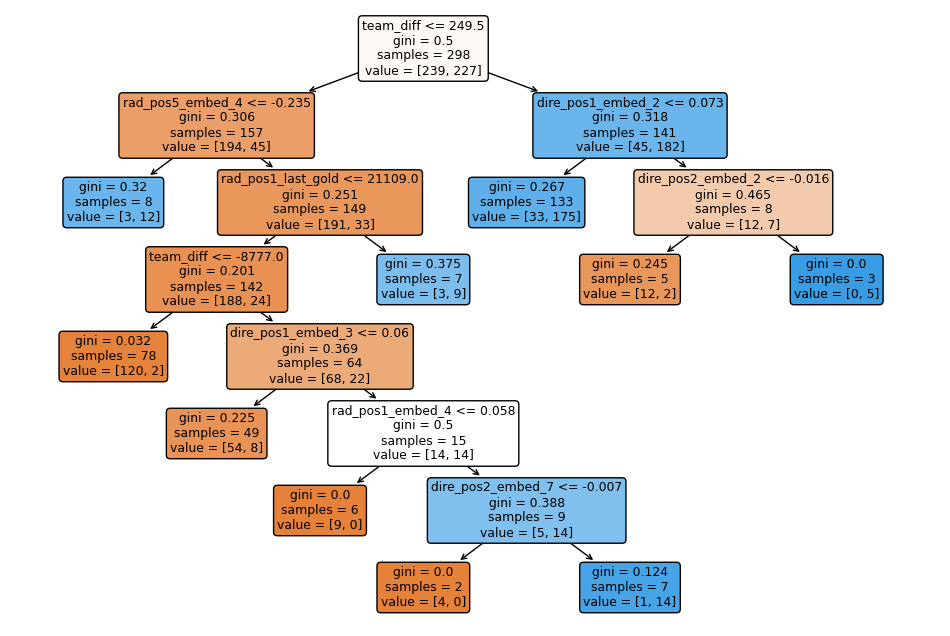

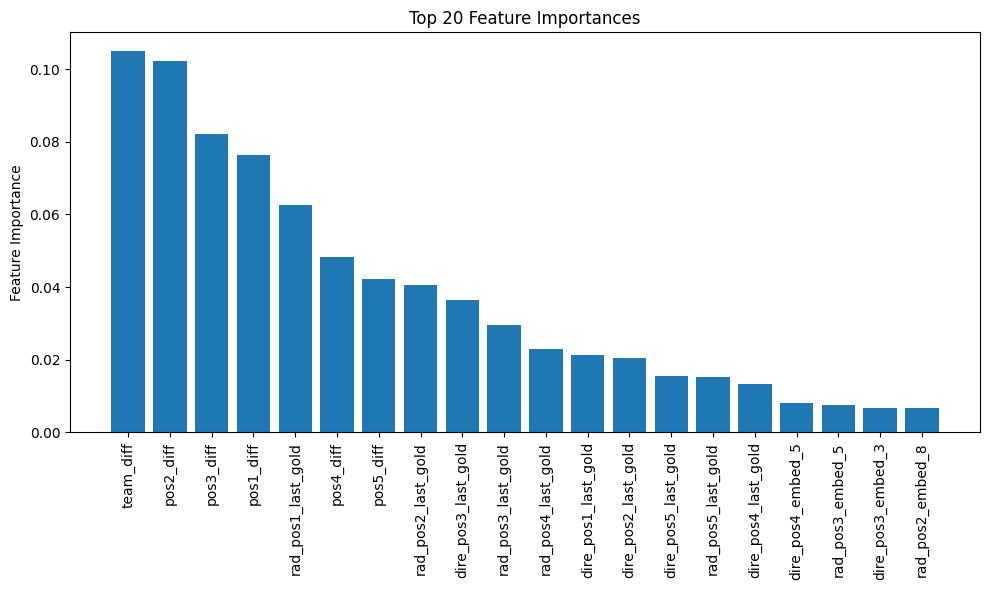

RF_30:        Acc      Prec   Recall        F1
0  0.78607  0.786151  0.78607  0.786091


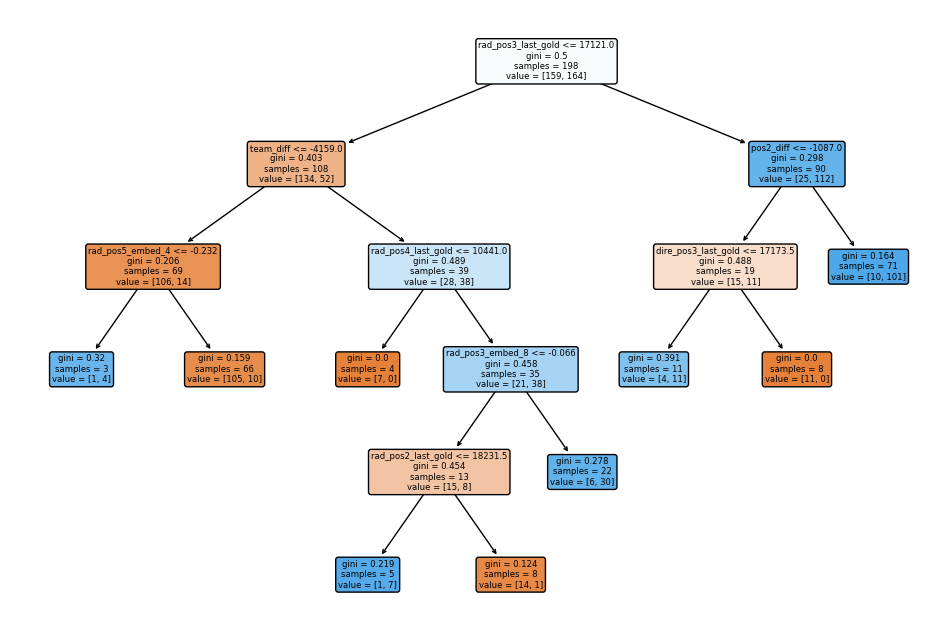

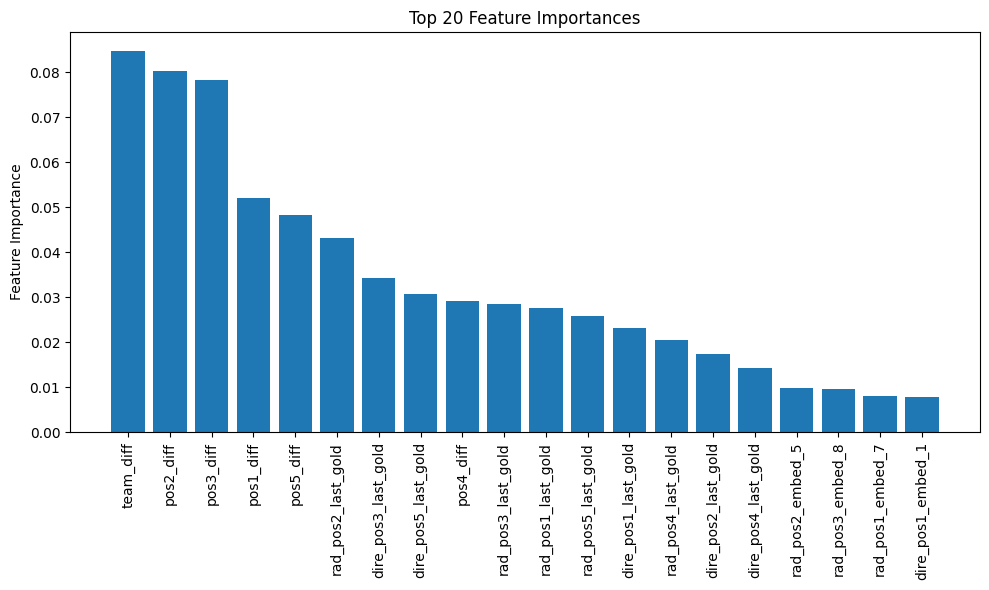

RF_35:         Acc      Prec    Recall        F1
0  0.791367  0.791188  0.791367  0.791236


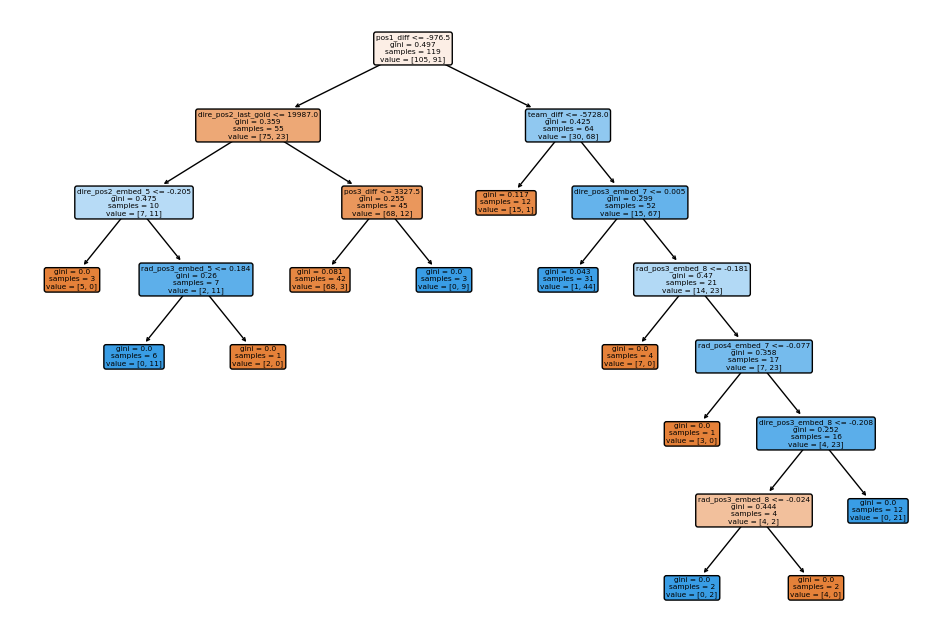

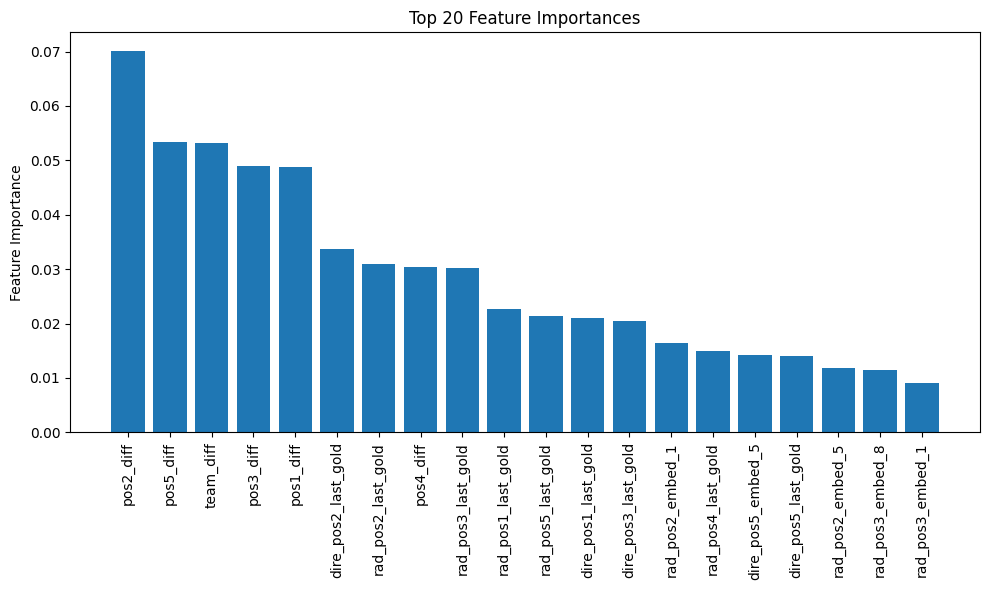

RF_40:         Acc      Prec    Recall        F1
0  0.776471  0.798115  0.776471  0.773724


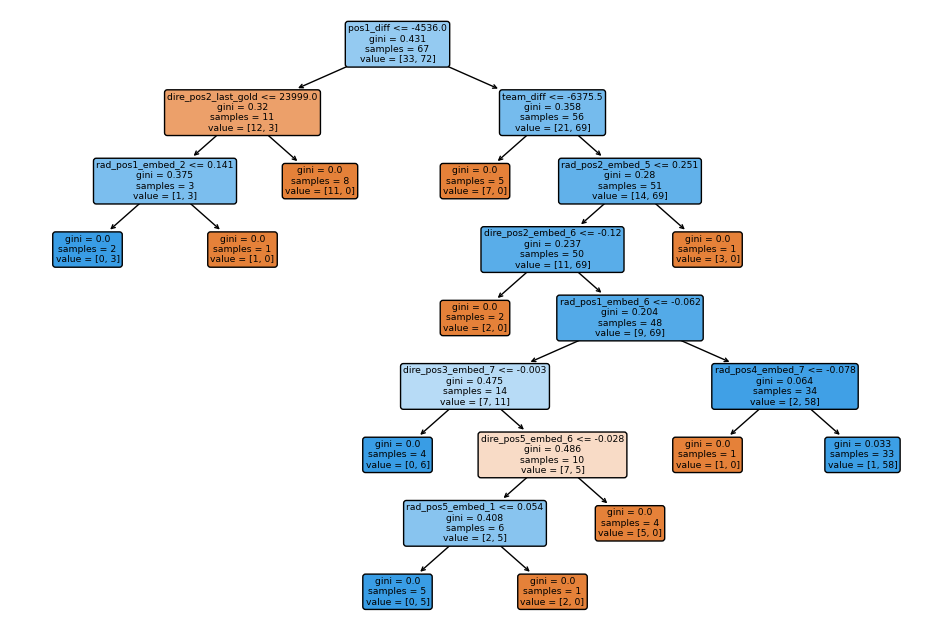

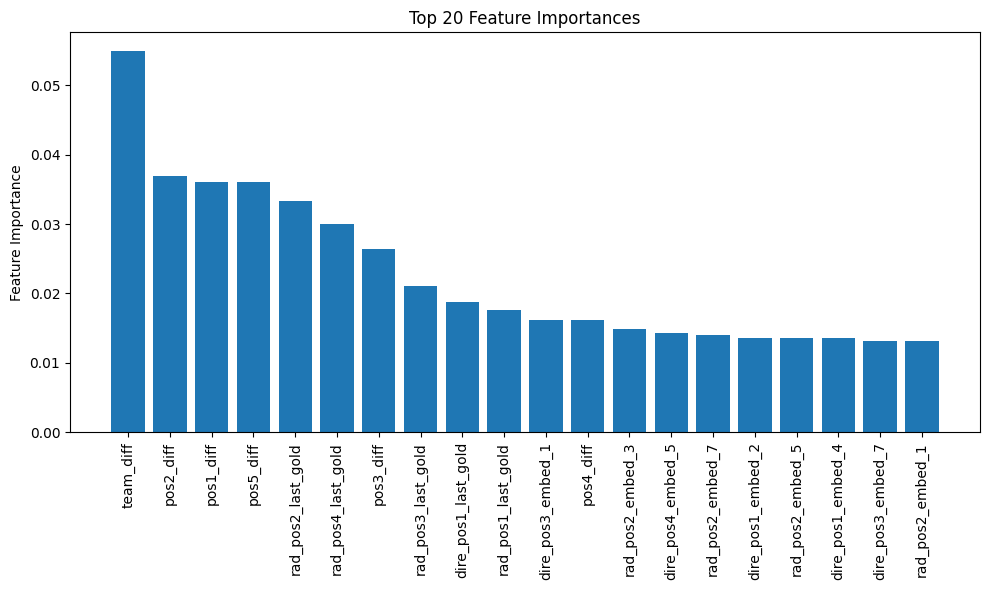

RF_45:         Acc   Prec    Recall        F1
0  0.688889  0.696  0.688889  0.691093


In [26]:
import warnings

warnings.filterwarnings('ignore')
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/embed_rf")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, ccp_alpha=0.01)


for i in range(15, 50, 5): # range does not include the last value i.e. 50 wont be included
    df_name = f'df_rf_{i}'
    df_name_embed = f'df_rf_{i}_embed'
    X_train_name = f'rf_{i}_X_train'
    X_test_name = f'rf_{i}_X_test'
    y_train_name = f'rf_{i}_y_train'
    y_test_name = f'rf_{i}_y_test'
    test_size = .30

    rf_class_name = f'rf_classifier_{i}'
    y_pred_name = f'y_pred_{i}'
    acc_name = f'acc_{i}'
    prec_name= f'prec_{i}'
    recall_name = f'recall_{i}'
    f1_name = f'f1_{i}'

    df_metrics_name = f'df_metrics_{i}'
    iteration = i

    #file_name = f'rf_{i}_no_embed'


    exec(f"{df_name} = drop_columns({df_name})")
    exec(f"{df_name_embed} = get_hero_embedding_and_concat_features({df_name})")
    exec(f"{X_train_name}, {X_test_name}, {y_train_name}, {y_test_name} = split_data({df_name_embed},{test_size})")

    # Saving indexes to be tested on with predicted values
    exec(f"os.chdir('/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/data/test_data')")
    exec(f"rf_y_test_index_{i} = {y_test_name}.index")
    exec(f"np.save('rf_y_test_index_{i}.npy', rf_y_test_index_{i})")

    exec(f"{rf_class_name} = rf_classifier.fit({X_train_name}, {y_train_name})")

    exec(f"os.chdir('/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/embed_rf')")
    exec(f"joblib.dump({rf_class_name}, '{rf_class_name}.pkl')")
    exec(f"{y_pred_name} = {rf_class_name}.predict({X_test_name})")
    exec(f"{acc_name} = accuracy_score({y_test_name},{y_pred_name})")
    exec(f"{prec_name} = precision_score({y_test_name}, {y_pred_name}, average='weighted')")
    exec(f"{recall_name} = recall_score({y_test_name}, {y_pred_name}, average='weighted')")
    exec(f"{f1_name} = f1_score({y_test_name}, {y_pred_name}, average='weighted')")


    exec(f"create_save_plots({rf_class_name},{X_test_name},{y_test_name},{df_name_embed},{iteration})")
    #rf_classifier_name, X_test_name, y_test_name, y_pred_name, df,file_name

    exec(f"{df_metrics_name} = pd.DataFrame([[{acc_name},{prec_name},{recall_name},{f1_name}]], columns =['Acc','Prec','Recall','F1'] )")
    exec(f"{df_metrics_name}.to_csv('RF_{i}_metrics.csv')")
    exec(f"print('RF_{i}:',{df_metrics_name})")

### XGBoost
This section will need to be altered to run with the specific LSTM model you want to use. Note that if you run the RF section above, you may not need to run the `get_hero_embeddings_and_concat` line since the df should already have the embed weight replacing the original hero values


#### Changing the Embed Representations
1. Pick your model from the model_dict list below
2. Change the lookback,horizon, embed_dim, and model_dict variables to match the model


#### Changing which df you want to run on
1. change the df passed to `get_hero_embedding_and_concat_features()`
2. You can keep the variables set to df_rf_15_embed and the like, but you need to change the metrics file name passed to `XGB_15_metrics.to_csv()`at line 69
3. You will also need to change the file name passed to plot_xgb_tree() at line 73

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/lstm")
model_dict_10_5_rmse_84 = torch.load('10step_5horizon_RMSE_84.pth') #done
model_dict_5_5_rmse_84 = torch.load('5step_5horizon_RMSE_84.pth') #error?
model_dict_10_5_rmse_8 = torch.load('10step_5horizon_RMSE_8.pth') #done
model_dict_5_5_rmse_8 = torch.load('5step_5horizon_RMSE_8.pth') #done

In [8]:
def plot_xgb_tree(best_model,file_name):
  from xgboost import plot_tree
  fig, ax = plt.subplots(figsize=(18, 14))  # Adjust the figsize as needed

# Plot the tree
  plot_tree(best_model, ax=ax)

  # Optionally, you can customize other aspects of the plot
  ax.set_title("XGBoost Decision Tree")
  ax.set_xlabel("Feature")
  ax.set_ylabel("Value")

  # plt.figure(figsize=(10, 6))
  # plt.title(f"XGB Best Decision Tree")
  # plot_tree(best_model)
  plt.savefig(f'{file_name}_Best_Tree.png')
  plt.show()

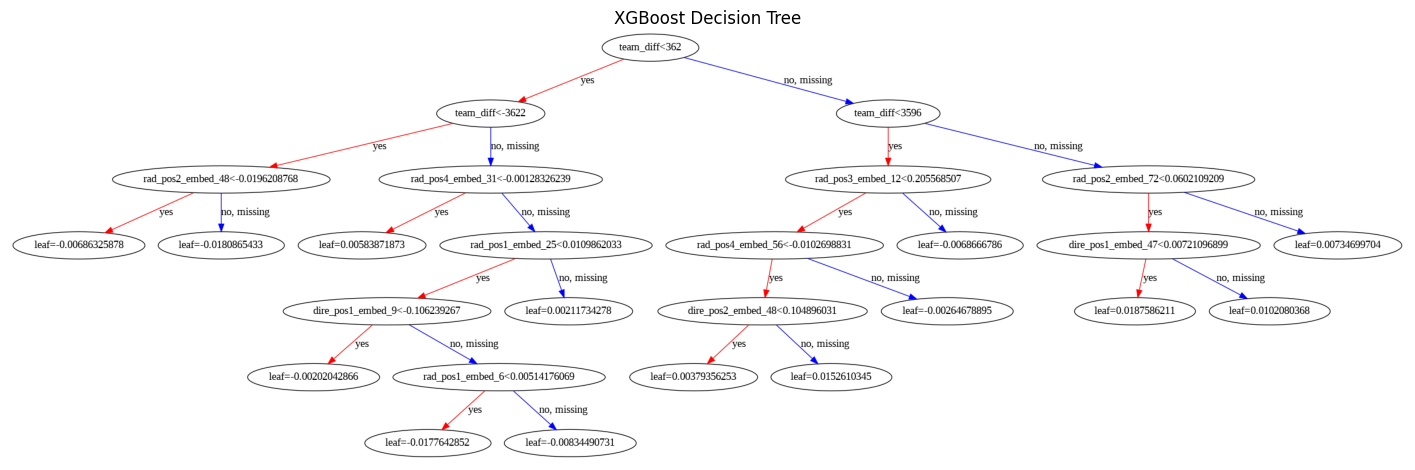

In [37]:
import warnings




# Choosing the model you want to load embedded weights to
lookback = 10
horizon = 5
embed_dim = 84
model_dict = model_dict_10_5_rmse_84
RMSE_embedding = ProcessEmbedding(df2_allhero, embedding_dim=embed_dim, lookback=lookback)
RMSE_embed_weights = model_dict['process_embedding.process_embeddings.weight']
RMSE_embedding.process_embeddings.weight = nn.Parameter(RMSE_embed_weights) # Load the old weights into the new embedding layer

warnings.filterwarnings('ignore')

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [200, 300],
    'max_depth':  [10],
    'learning_rate': [0.01], #,0.1],
    'subsample': [0.8], #,1.0],
    'colsample_bytree': [0.8], #, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 5, 10]
}

df_rf_15_embed = get_hero_embedding_and_concat_features(df_rf_15) # Replace the hero columns with their embedded weight representations

rf_15_X_train, rf_15_X_test, rf_15_y_train, rf_15_y_test = split_data(df_rf_15_embed, test_size = .30)

rf_15_y_train_binary = rf_15_y_train.replace({'dire': 0, 'radiant': 1})
label_mapping = {'dire': 0, 'radiant': 1}
label_mapper = np.vectorize(lambda x: label_mapping[x])


# Create an instance of XGBClassifier
xgbclass = XGBClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgbclass, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(rf_15_X_train, rf_15_y_train_binary)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(rf_15_X_test)
#rf_15_y_pred_binary = label_mapper(y_pred)

# Evaluate the model
accuracy = accuracy_score(rf_15_y_test_binary, y_pred)
precision = precision_score(rf_15_y_test_binary, y_pred, average='weighted')
recall = recall_score(rf_15_y_test_binary, y_pred, average='weighted')
f1 = f1_score(rf_15_y_test_binary, y_pred, average='weighted')

print(f"Best parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/embed_xgb")
XGB_metrics_15 = pd.DataFrame([[accuracy,precision,recall,f1]], columns = ['Acc','Prec','Recall','F1'])
XGB_metrics_15.to_csv('XGB_15_metrics.csv')
print(XGB_metrics_15)

os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots/embed_xgb")
plot_xgb_tree(best_model,'XGB_15')

Automated

Pick the LSTM model you want for the embedding by loading the model dict below, setting it equal to the variable `model_dict`and let it rip.

Later when you want to include the predicted value, load that model in the Predicting on RF Structures notebook, and let that rip as well.

In [34]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/lstm")
# model_dict_10_5_rmse_84 = torch.load('10step_5horizon_RMSE_84.pth') #done
# model_dict_5_5_rmse_84 = torch.load('5step_5horizon_RMSE_84.pth') #error?
# model_dict_10_5_rmse_8 = torch.load('10step_5horizon_RMSE_8.pth') #done
# model_dict_5_5_rmse_8 = torch.load('5step_5horizon_RMSE_8.pth') #done

model_dict_10_1_rmse_8 = torch.load('10step_1horizon_RMSE_8.pth') #done
model_dict = model_dict_10_1_rmse_8
embed_dim = 8
lookback = 10
horizon = 1

file_name = '10_1_8'

RMSE_embedding = ProcessEmbedding(df2_allhero, embedding_dim=embed_dim, lookback=lookback)
RMSE_embed_weights = model_dict['process_embedding.process_embeddings.weight']
RMSE_embedding.process_embeddings.weight = nn.Parameter(RMSE_embed_weights) # Load the old weights into the new embedding layer


param_grid = {
    'n_estimators': [200, 300],
    'max_depth':  [10],
    'learning_rate': [0.01 ,0.1],
    'subsample': [0.8 ,1.0],
    'colsample_bytree': [0.8 , 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 5, 10]
}

Best parameters for iteration 15: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
Accuracy for iteration 15: 0.6756
Precision for iteration 15: 0.6780
Recall for iteration 15: 0.6756
F1-score for iteration 15: 0.6734
XGB_metrics for iteration 15:
        Acc      Prec    Recall        F1
0  0.675585  0.678049  0.675585  0.673433


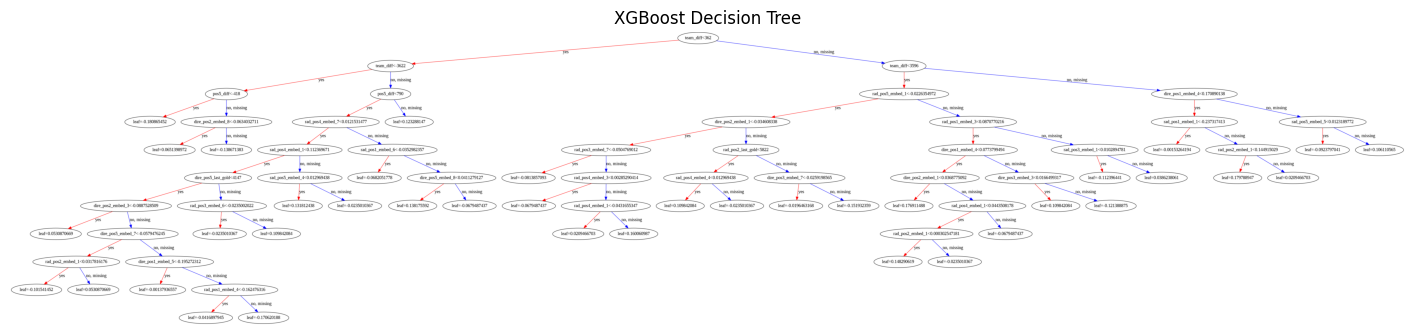

Best parameters for iteration 20: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}
Accuracy for iteration 20: 0.7439
Precision for iteration 20: 0.7440
Recall for iteration 20: 0.7439
F1-score for iteration 20: 0.7440
XGB_metrics for iteration 20:
        Acc      Prec    Recall        F1
0  0.743945  0.744028  0.743945  0.743951


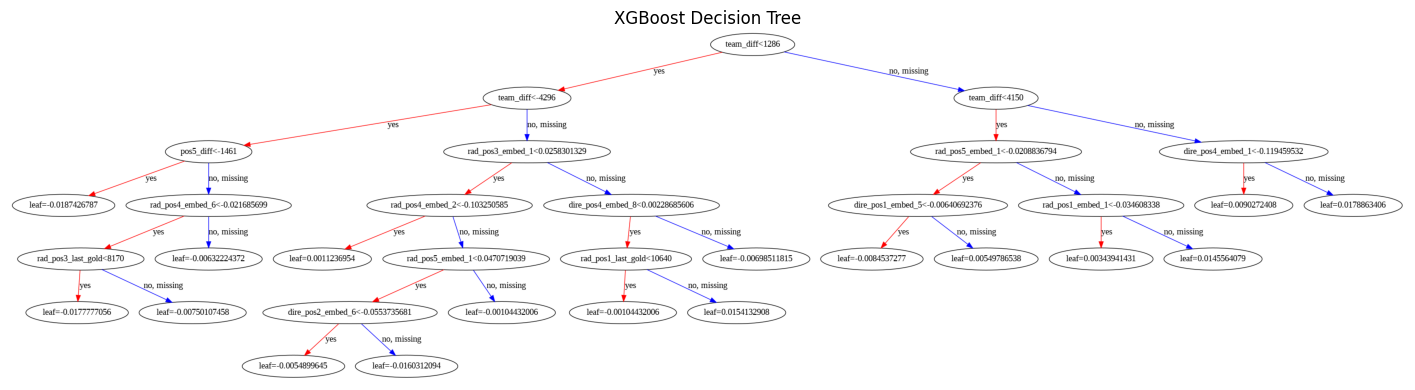

Best parameters for iteration 25: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Accuracy for iteration 25: 0.7874
Precision for iteration 25: 0.7882
Recall for iteration 25: 0.7874
F1-score for iteration 25: 0.7870
XGB_metrics for iteration 25:
        Acc      Prec    Recall        F1
0  0.787402  0.788232  0.787402  0.787031


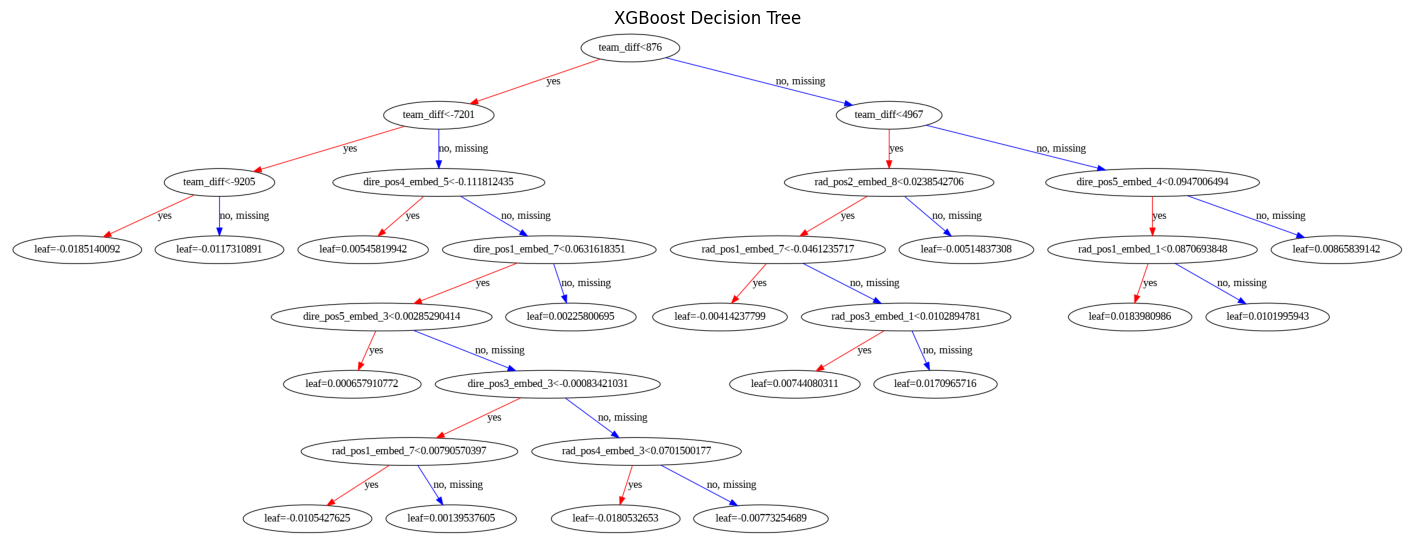

Best parameters for iteration 30: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 300, 'subsample': 0.8}
Accuracy for iteration 30: 0.7662
Precision for iteration 30: 0.7665
Recall for iteration 30: 0.7662
F1-score for iteration 30: 0.7659
XGB_metrics for iteration 30:
        Acc      Prec    Recall        F1
0  0.766169  0.766541  0.766169  0.765879


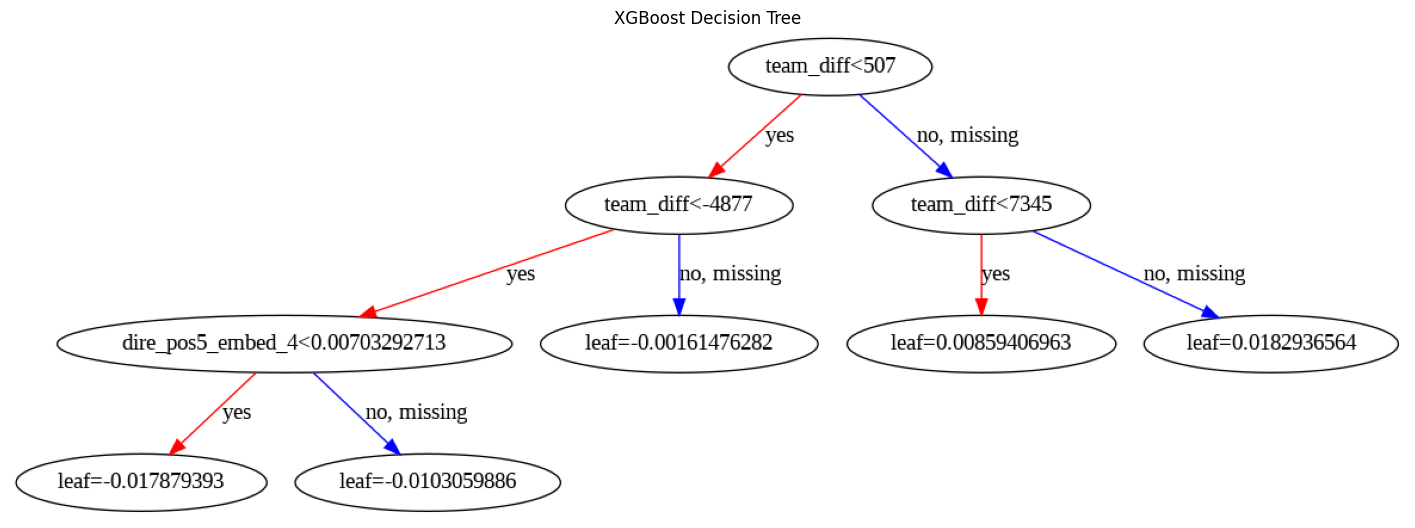

Best parameters for iteration 35: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy for iteration 35: 0.7698
Precision for iteration 35: 0.7695
Recall for iteration 35: 0.7698
F1-score for iteration 35: 0.7695
XGB_metrics for iteration 35:
        Acc     Prec    Recall        F1
0  0.769784  0.76948  0.769784  0.769472


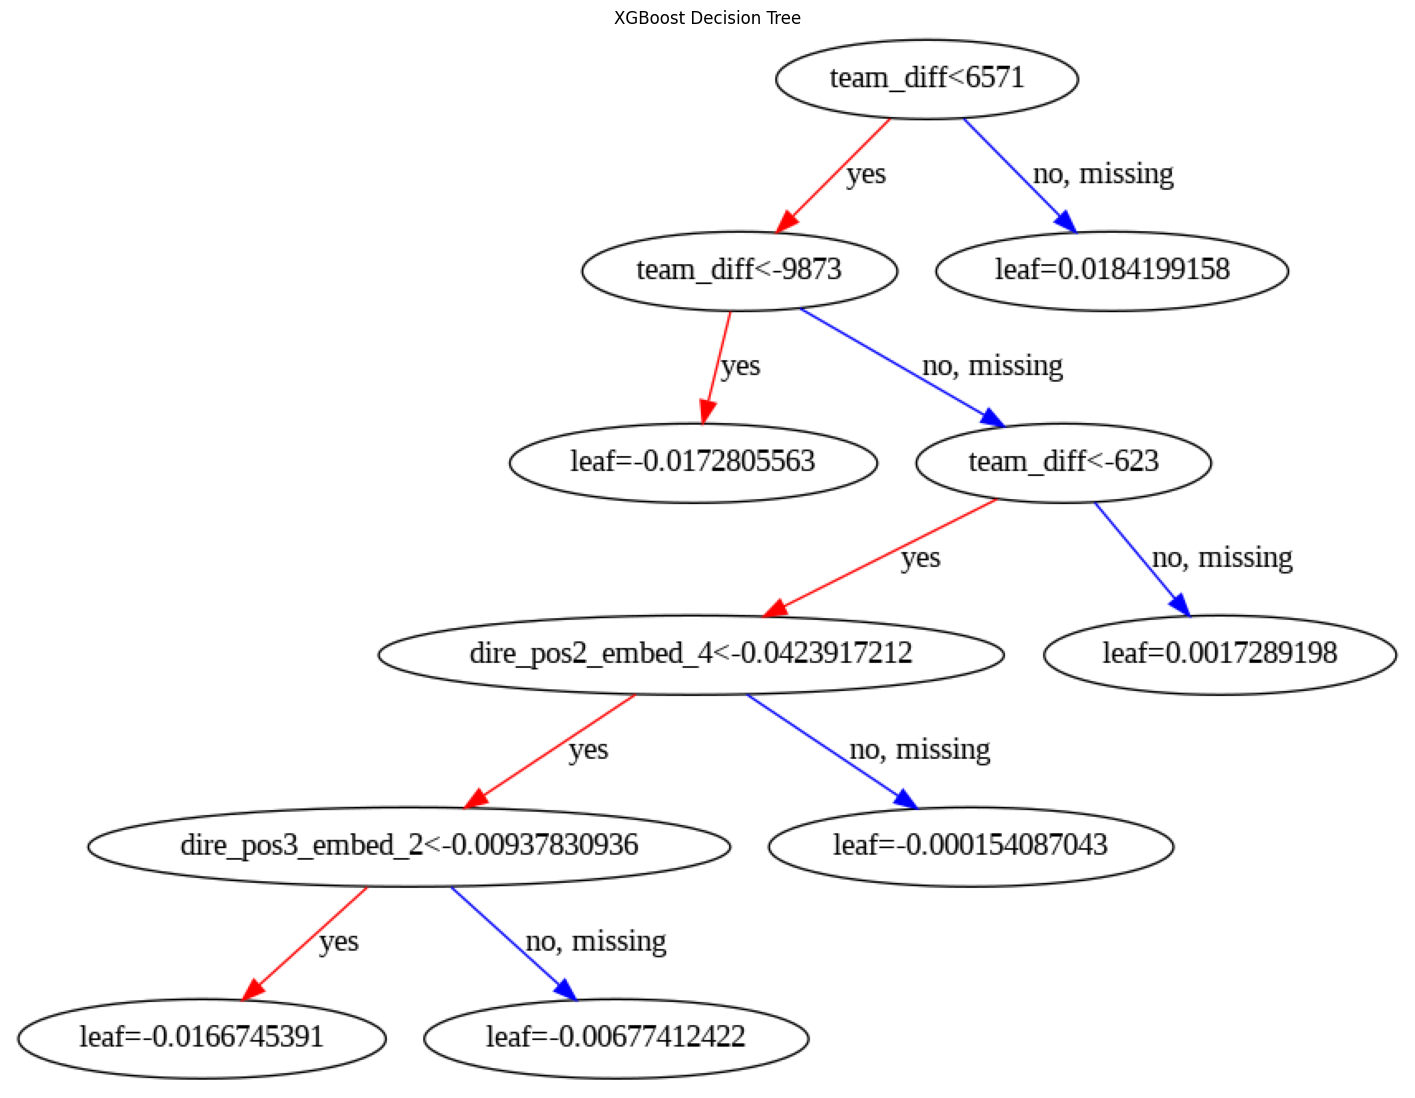

Best parameters for iteration 40: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 300, 'subsample': 0.8}
Accuracy for iteration 40: 0.7529
Precision for iteration 40: 0.7575
Recall for iteration 40: 0.7529
F1-score for iteration 40: 0.7526
XGB_metrics for iteration 40:
        Acc      Prec    Recall        F1
0  0.752941  0.757499  0.752941  0.752599


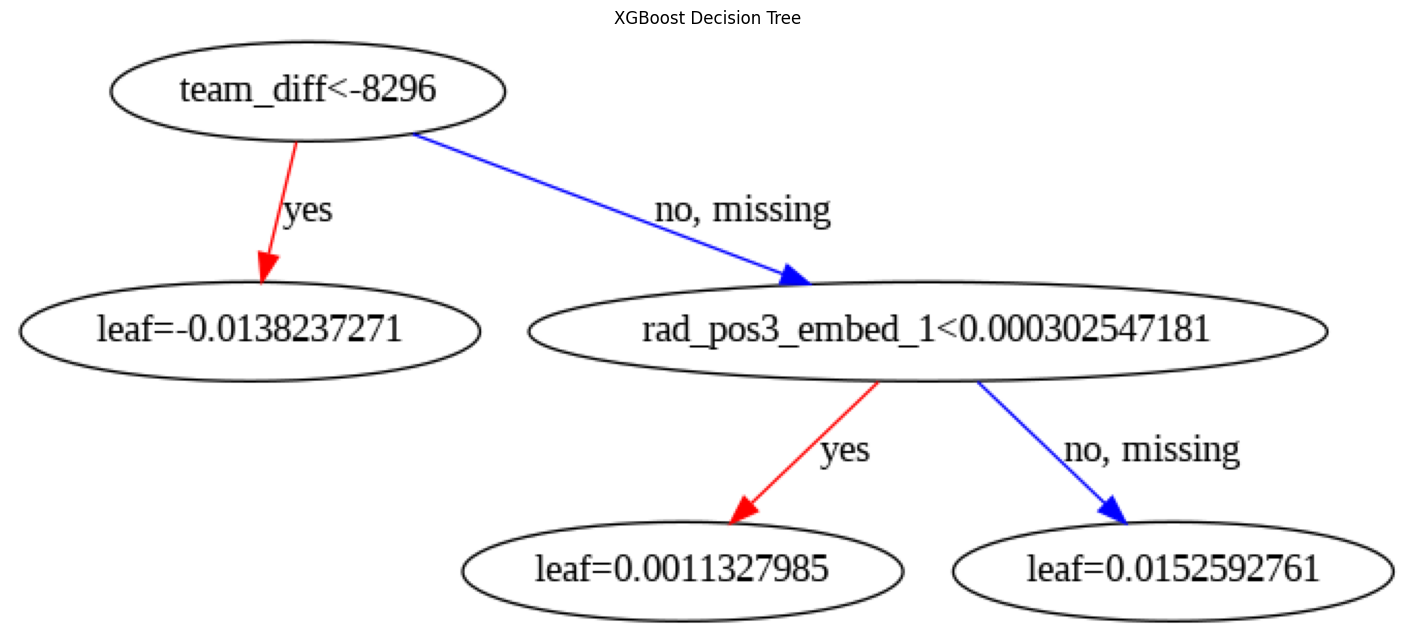

Best parameters for iteration 45: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy for iteration 45: 0.7111
Precision for iteration 45: 0.7344
Recall for iteration 45: 0.7111
F1-score for iteration 45: 0.7140
XGB_metrics for iteration 45:
        Acc      Prec    Recall        F1
0  0.711111  0.734387  0.711111  0.713987


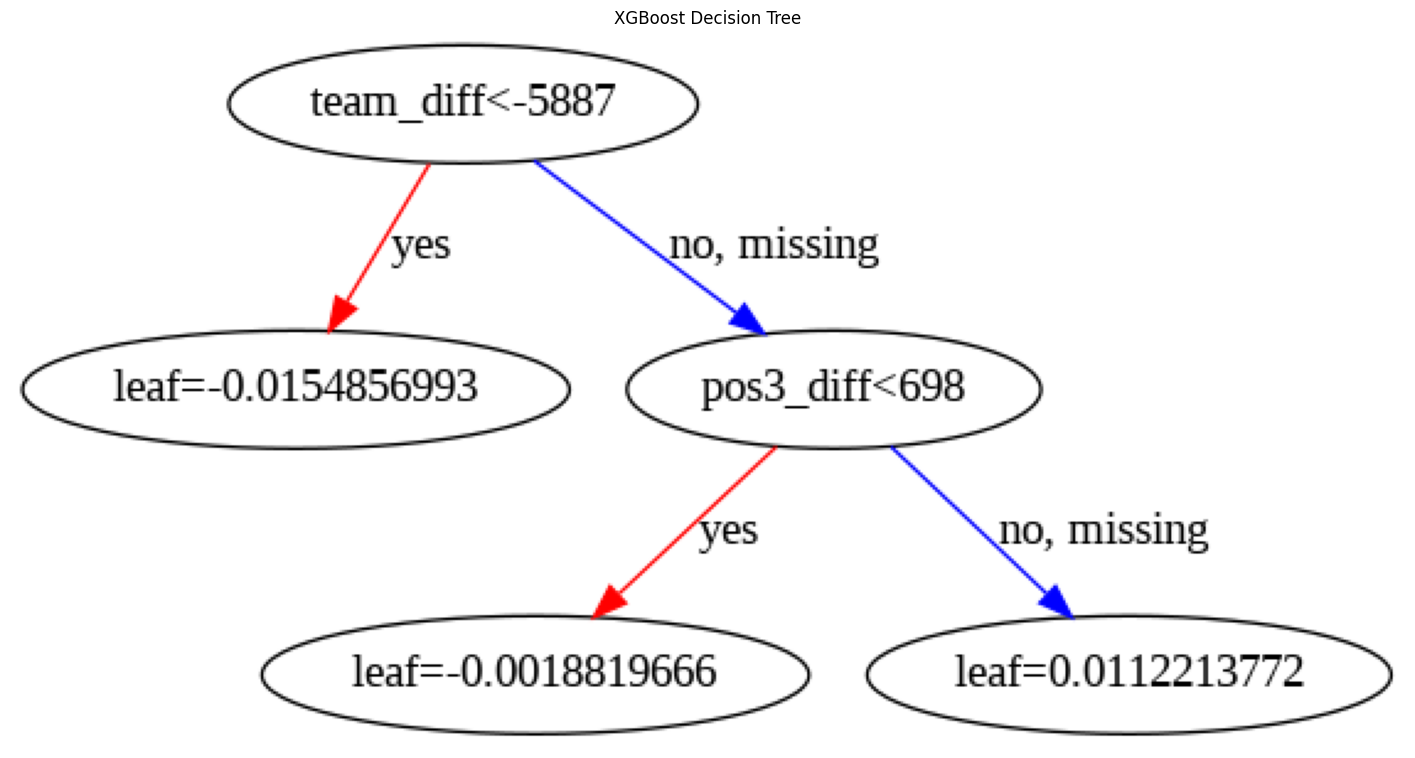

In [35]:
dataframes = [df_rf_15, df_rf_20, df_rf_25, df_rf_30, df_rf_35, df_rf_40, df_rf_45]
iterations = [15, 20, 25, 30, 35, 40, 45]

for df, iteration in zip(dataframes, iterations):
    df_embed = get_hero_embedding_and_concat_features(df)
    X_train, X_test, y_train, y_test = split_data(df_embed, test_size=.30)
    y_train_binary = y_train.replace({'dire': 0, 'radiant': 1})
    label_mapping = {'dire': 0, 'radiant': 1}
    label_mapper = np.vectorize(lambda x: label_mapping[x])

    y_test_binary = y_test.replace({'dire': 0, 'radiant': 1})


    # Saving Indexes of test data
    os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/data/test_data")
    xg_y_test_index = y_test.index
    np.save(f'xg_y_test_index_{iteration}.npy', xg_y_test_index)

    # Create an instance of XGBClassifier
    xgbclass = XGBClassifier(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=xgbclass, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train_binary)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Save that son of a gun
    os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/embed_xgb")
    joblib.dump(best_model, f'XGB_{iteration}_model_embed.pkl')

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred, average='weighted')
    recall = recall_score(y_test_binary, y_pred, average='weighted')
    f1 = f1_score(y_test_binary, y_pred, average='weighted')

    print(f"Best parameters for iteration {iteration}: {grid_search.best_params_}")
    print(f"Accuracy for iteration {iteration}: {accuracy:.4f}")
    print(f"Precision for iteration {iteration}: {precision:.4f}")
    print(f"Recall for iteration {iteration}: {recall:.4f}")
    print(f"F1-score for iteration {iteration}: {f1:.4f}")

    os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/models/embed_xgb")
    XGB_metrics = pd.DataFrame([[accuracy, precision, recall, f1]], columns=['Acc', 'Prec', 'Recall', 'F1'])
    XGB_metrics.to_csv(f'XGB_{iteration}_metrics.csv')
    print(f"XGB_metrics for iteration {iteration}:\n{XGB_metrics}")

    os.chdir("/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots/embed_xgb")
    plot_xgb_tree(best_model, f'XGB_{iteration}')
    feature_importances = best_model.feature_importances_
    feature_names = X_train.columns
    sorted_idx = feature_importances.argsort()[::-1]
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
    plt.xticks(range(len(feature_importances)), feature_names[sorted_idx], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance (Iteration {iteration})')
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/698/10step_5horizon/plots/embed_xgb/XGB_{iteration}_feature_importance.png")
    plt.show()